In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from hurst import compute_Hc, random_walk
import numba as nb
os.chdir("/Users/kuanlim/Documents/24. DEX Validation")

from alive_progress import alive_bar  

In [2]:
@nb.njit(fastmath=True)
def mgf_jump(q,eta_p,eta_n,t=0):
    return q/(1-t*eta_p)+(1-q)/(1+t*eta_n)

@nb.njit(fastmath=True)
def inv_J_cdf_mv(cdf,q,eta_p,eta_n):
    if cdf<1-q:
        return eta_n*np.log(cdf/(1-q))
    else:
        return-eta_p*np.log((1-cdf)/(q))

@nb.njit(fastmath=True)
def DEX_log_returns(index,n=1000000):
    dt = 1/365/86400
    mu = 0
    vol = 0.25
    decay = 175200
    
    if index == 'DEX U900':
        vol = 0.25
        decay = 175200
        eta_p = 0.30/100
        eta_n = 0.04/100
        q = 0.2
    elif index == 'DEX D900':
        vol = 0.25
        decay = 175200
        eta_p = 0.04/100
        eta_n = 0.30/100
        q = 0.8
    elif index == 'DEX U600':
        vol = 0.2
        decay = 30 * 24 * 365
        eta_p = 0.2/100
        eta_n = 0.04/100
        q = 0.2
    elif index == 'DEX D600':
        vol = 0.2
        decay = 30 * 24 * 365
        eta_p = 0.04/100
        eta_n = 0.20/100
        q = 0.8
    elif index == 'DEX U1500':
        vol = 0.1
        decay = 6 * 24 * 365
        eta_p = 0.2/100
        eta_n = 0.04/100
        q = 0.4
    elif index == 'DEX D1500':
        vol = 0.1
        decay = 6 * 24 * 365
        eta_p = 0.04/100
        eta_n = 0.2/100
        q = 0.6

    a=mgf_jump(q,eta_p,eta_n,t=1)-1

    W = np.zeros(n)
    N = np.zeros(n)
    jumps = np.zeros(n)

    for i in nb.prange(n):
        W[i] = np.random.normal()
        N[i] = np.random.poisson(decay * dt)
    
    for i in range(n):
        jump = 0
        for _ in range(N[i]):
            jump += inv_J_cdf_mv(np.random.uniform(),q,eta_p,eta_n)
            pass
        jumps[i] = jump

    log_S = np.zeros(n+1)

    for i in nb.prange(n):
        log_S[i+1] = (mu-vol**2/2-decay*a)*dt + vol*np.sqrt(dt) * W[i] + jumps[i]
        pass
    return log_S 

def DEX_sim(index, n=1000000):
    S0 = 10000
    log_S = DEX_log_returns(index, n)
    return S0 * np.exp(np.cumsum(log_S))

In [3]:
n = 86400*30
n_sim = 100
dex_indices = ["DEX D600","DEX D900","DEX D1500"]

sim_result = []
for index in dex_indices:

    if index == "DEX D600":

        t_exclude = 10*60
        interval = 10*60
        jump_size = -0.2/100

    elif index == "DEX D900":
        t_exclude = 15*60
        interval = 15*60
        jump_size = -0.3/100

    elif index == "DEX D1500":     
        t_exclude = 25*60
        interval = 25*60
        jump_size = -0.2/100
    
    
    for i in range(n_sim):
        S_mv=DEX_sim(index,n=n)

        test = pd.DataFrame(S_mv,columns=['mid'])
        test['return'] = test.mid.pct_change()
        test = test.reset_index()

        jump = test[test['return']<jump_size].index

        result = []
        for i in range(len(jump)-1):
            if (jump[i+1]-jump[i]) < t_exclude:
                next
            else:
                j=1
                entry_time = jump[i]+t_exclude
                while entry_time < jump[i+1]:

                    entry_price = test['mid'].iloc[entry_time]
                    avg_price = np.mean(test['mid'].iloc[jump[i]+t_exclude:jump[i+1]])
                    exit_price = test['mid'].iloc[jump[i+1]]
                    result.append([entry_time,jump[i+1],entry_price,avg_price,exit_price,entry_price-exit_price])
                    entry_time += interval
                    j+=1

        tep = pd.DataFrame(result)
        tep.columns = ['entry','exit','ent_spot','avg_spot','ext_spot','pl']
        tep['hold_time'] = (tep.exit - tep.entry)
        tep['return'] =tep.pl/tep.ent_spot

        gb_exit = tep.groupby("exit").agg({'pl':'sum'})
        win_rate = len(gb_exit[gb_exit.pl>0])/len(gb_exit)
        hit_ratio = np.sum(np.where(gb_exit.pl>0,gb_exit.pl,0))/np.sum(np.where(gb_exit.pl>0,gb_exit.pl,-gb_exit.pl))

        sim_result.append([index,i,tep.pl.sum(),len(tep),hit_ratio,win_rate,tep.pl.mean(),tep.pl.median(),tep['return'].mean(),tep['return'].median()])

strategy_result = pd.DataFrame(sim_result)
strategy_result.columns = ['index','sim','Total PL','Total Trades','Hit Ratio','Win Rate','Mean PL','Median PL','Mean Return','Median Return']

In [6]:
strategy_result = pd.read_csv("/Users/kuanlim/Documents/24. DEX Validation/strategy_result.csv")
# strategy_result.columns = ['index','sim','Total PL','Total Trades','Hit Ratio','Win Rate','Mean PL','Median PL','Mean Return','Median Return']

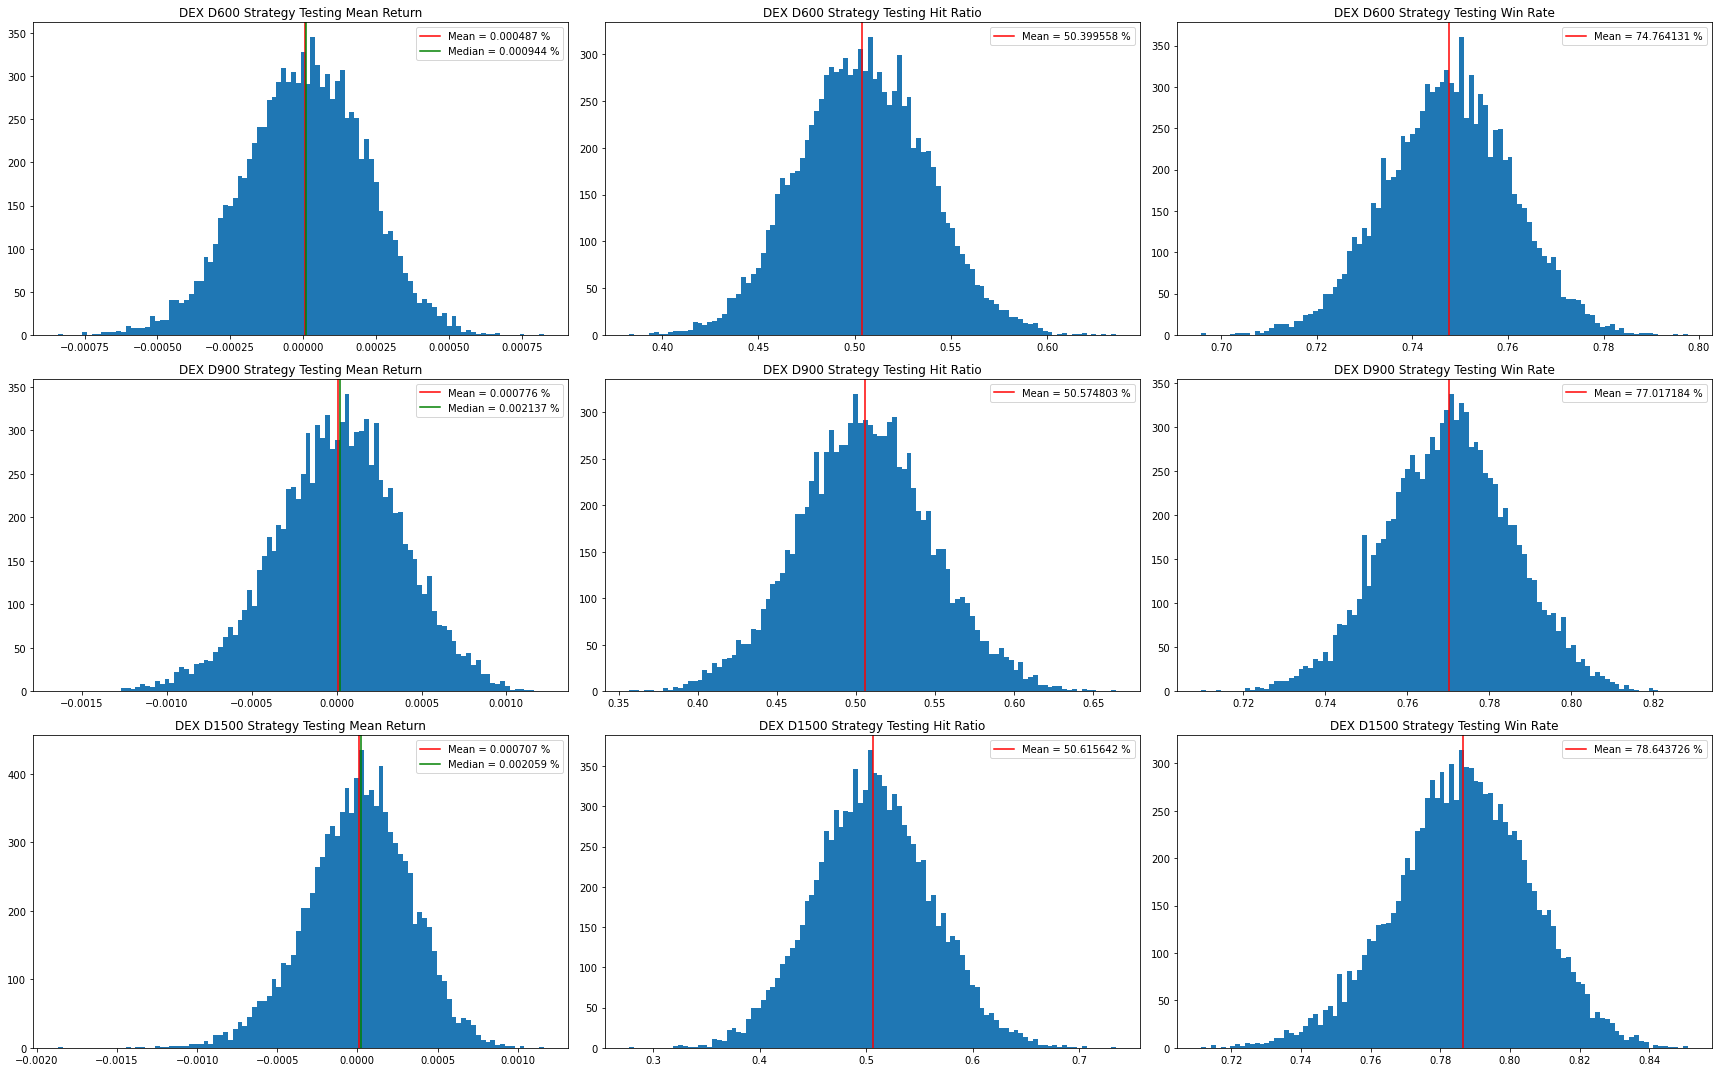

In [7]:
fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(24,15))
i=0

for index in dex_indices:

    # Mean Return
    df_plot = strategy_result[strategy_result['index']==index]['Mean Return']
    ax[i,0].hist(df_plot,bins=100)
    ax[i,0].set_title(f"{index} Strategy Testing Mean Return")
    mean_return = df_plot.mean()
    median_return = df_plot.median()
    ax[i,0].axvline(mean_return,color='red',label = f"Mean = {mean_return*100:.6f} %")
    ax[i,0].axvline(median_return,color='green',label = f"Median = {median_return*100:.6f} %")
    ax[i,0].legend()

    # Hit Ratio
    df_plot = strategy_result[strategy_result['index']==index]['Hit Ratio']
    ax[i,1].hist(df_plot,bins=100)
    ax[i,1].set_title(f"{index} Strategy Testing Hit Ratio")
    mean_return = df_plot.mean()
    median_return = df_plot.median()
    ax[i,1].axvline(mean_return,color='red',label = f"Mean = {mean_return*100:.6f} %")
    ax[i,1].legend()

    # Win Rate 
    df_plot = strategy_result[strategy_result['index']==index]['Win Rate']
    ax[i,2].hist(df_plot,bins=100)
    ax[i,2].set_title(f"{index} Strategy Testing Win Rate")
    mean_return = df_plot.mean()
    median_return = df_plot.median()
    ax[i,2].axvline(mean_return,color='red',label = f"Mean = {mean_return*100:.6f} %")
    ax[i,2].legend()
    

    
    i+=1

plt.tight_layout()

plt.show()